In [30]:
import pandas as pd
from pathlib import Path
from collections import Counter
import re
from corpus_processing import PROCESSED_DATA_PATH, PROCESSED_DATA_PATH_PICKLE
import matplotlib.pyplot as plt

In [26]:
ONLY_WORDS_AND_DIGITS_REGEX = re.compile(r'[\w\dא-ת]+')
def get_only_words_and_digits(text: str):
    return ONLY_WORDS_AND_DIGITS_REGEX.findall(text)

def text_to_word_list(text: str):
    return get_only_words_and_digits(text)
    #return text.split()

def invert_words(words: list):
    return [w[::-1] for w in words]

In [27]:
def words_count(texts: pd.Series):
    texts_split = pd.Series((text_to_word_list(text) for text in texts))

    return texts_split.map(lambda x: len(x)).hist()

In [28]:
def most_common_words(texts: pd.Series, n: int, stopwords: list = None):
    if stopwords is None:
	    stopwords = []
    words_counter = Counter()
    for text in texts:
        for word in text_to_word_list(text):
            if word not in stopwords:
                words_counter[word] += 1
    sorted_word_count = sorted(words_counter.items(), key=lambda x:x[1], reverse=True)
    with open("word_count_all_text.txt", 'w', encoding='utf-8') as f:
        for item in sorted_word_count:
            f.write(item[0] + " : " + str(item[1]))
            f.write("\n")
    words, count = zip(*sorted_word_count[:n])
    words = invert_words(words)
    fig = plt.figure(figsize=(15,10))
    return plt.bar(words, count)


<BarContainer object of 20 artists>

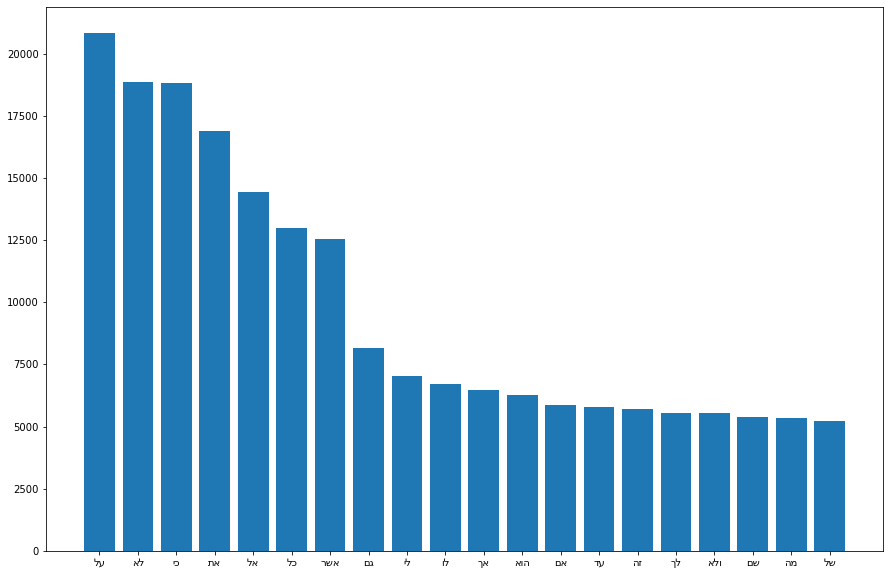

In [31]:
#df = pd.read_csv(PROCESSED_DATA_PATH)
df = pd.read_pickle(PROCESSED_DATA_PATH_PICKLE)

most_common_words(df.content, 20)

In [56]:
def plot_word_number_histogram(text: pd.Series):
    return text.map(lambda x: len(text_to_word_list(x))).hist(bins=50)

249.855596696098


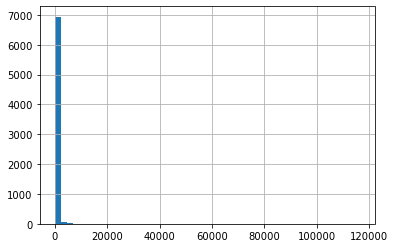

In [62]:
plot_word_number_histogram(df.content)
df['words_count'] = df.content.map(lambda x: len(text_to_word_list(x)))
df.to_csv("words_count.csv", columns=["ID","title","authors","genre","words_count"])

In [ ]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
import pyLDAvis.gensim


def get_lda_objects(text, stop):

    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words= text_to_word_list(news)

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 6,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)

    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis